In [1]:
pip install scikit-image scikit-learn opencv-python numpy matplotlib


   ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
   --- ------------------------------------ 1.0/12.9 MB 9.4 MB/s eta 0:00:02
   --------- ------------------------------ 3.1/12.9 MB 9.1 MB/s eta 0:00:02
   ----------------- ---------------------- 5.8/12.9 MB 10.3 MB/s eta 0:00:01
   --------------------- ------------------ 6.8/12.9 MB 8.9 MB/s eta 0:00:01
   ------------------------ --------------- 7.9/12.9 MB 8.2 MB/s eta 0:00:01
   --------------------------- ------------ 8.9/12.9 MB 7.5 MB/s eta 0:00:01
   ------------------------------- -------- 10.2/12.9 MB 7.2 MB/s eta 0:00:01
   ---------------------------------- ----- 11.3/12.9 MB 7.1 MB/s eta 0:00:01
   ---------------------------------------  12.6/12.9 MB 6.9 MB/s eta 0:00:01
   ---------------------------------------- 12.9/12.9 MB 6.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ------------------------------ --------- 1.3/1.7 MB 6.4 MB/s eta 0:00:01
   ------


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [18]:
data_dir = "E:\MACHINE LEARNING\BASICS\DIP PROJECTS\seg_train\seg_train"
classes = os.listdir(data_dir)
print("Classes found:", classes)


Classes found: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


<>:1: SyntaxWarning: invalid escape sequence '\M'
<>:1: SyntaxWarning: invalid escape sequence '\M'
C:\Users\HP\AppData\Local\Temp\ipykernel_8432\3126914140.py:1: SyntaxWarning: invalid escape sequence '\M'
  data_dir = "E:\MACHINE LEARNING\BASICS\DIP PROJECTS\seg_train\seg_train"


In [19]:
def compute_glcm(image, distance=1, angle=0):
    rows, cols = image.shape
    levels = 256
    glcm = np.zeros((levels, levels), dtype=np.uint32)

    dx, dy = 0, 0
    if angle == 0:  # 0°
        dx, dy = distance, 0
    elif angle == 90:
        dx, dy = 0, distance
    elif angle == 45:
        dx, dy = distance, -distance
    elif angle == 135:
        dx, dy = distance, distance

    for i in range(rows):
        for j in range(cols):
            i2, j2 = i + dy, j + dx
            if 0 <= i2 < rows and 0 <= j2 < cols:
                a = image[i, j]
                b = image[i2, j2]
                glcm[a, b] += 1

    glcm = glcm + glcm.T 
    glcm = glcm.astype(np.float64)
    glcm /= glcm.sum() 
    return glcm

In [20]:
def glcm_features(glcm):
    contrast = 0
    dissimilarity = 0
    homogeneity = 0
    energy = 0
    correlation = 0

    mean_i = np.sum([i * np.sum(glcm[i, :]) for i in range(256)])
    mean_j = np.sum([j * np.sum(glcm[:, j]) for j in range(256)])
    std_i = np.sqrt(np.sum([(i - mean_i) ** 2 * np.sum(glcm[i, :]) for i in range(256)]))
    std_j = np.sqrt(np.sum([(j - mean_j) ** 2 * np.sum(glcm[:, j]) for j in range(256)]))

    for i in range(256):
        for j in range(256):
            pij = glcm[i, j]
            contrast += (i - j) ** 2 * pij
            dissimilarity += abs(i - j) * pij
            homogeneity += pij / (1 + (i - j) ** 2)
            energy += pij ** 2
            if std_i > 0 and std_j > 0:
                correlation += ((i - mean_i) * (j - mean_j) * pij) / (std_i * std_j)

    return [contrast, dissimilarity, homogeneity, energy, correlation]

In [21]:
X = []
y = []

In [22]:
for label in classes:
    class_dir = os.path.join(data_dir, label)
    for img_name in os.listdir(class_dir)[:200]:  
        img_path = os.path.join(class_dir, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (128, 128))
        glcm = compute_glcm(img, distance=1, angle=0)
        features = glcm_features(glcm)
        X.append(features)
        y.append(label)

In [23]:
X = np.array(X)
y = LabelEncoder().fit_transform(y)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, pred_rf))

Random Forest Accuracy: 0.525


In [26]:
svm = SVC(kernel='rbf', C=10)
svm.fit(X_train, y_train)
pred_svm = svm.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, pred_svm))

SVM Accuracy: 0.35833333333333334


In [27]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
pred_knn = knn.predict(X_test)
print("KNN Accuracy:", accuracy_score(y_test, pred_knn))

KNN Accuracy: 0.31666666666666665


In [28]:
print("\nClassification Report (Random Forest):\n", classification_report(y_test, pred_rf))


Classification Report (Random Forest):
               precision    recall  f1-score   support

           0       0.50      0.56      0.53        39
           1       0.80      0.83      0.82        48
           2       0.29      0.40      0.34        35
           3       0.38      0.32      0.34        38
           4       0.56      0.42      0.48        45
           5       0.59      0.54      0.57        35

    accuracy                           0.53       240
   macro avg       0.52      0.51      0.51       240
weighted avg       0.53      0.53      0.53       240



In [29]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [30]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [32]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

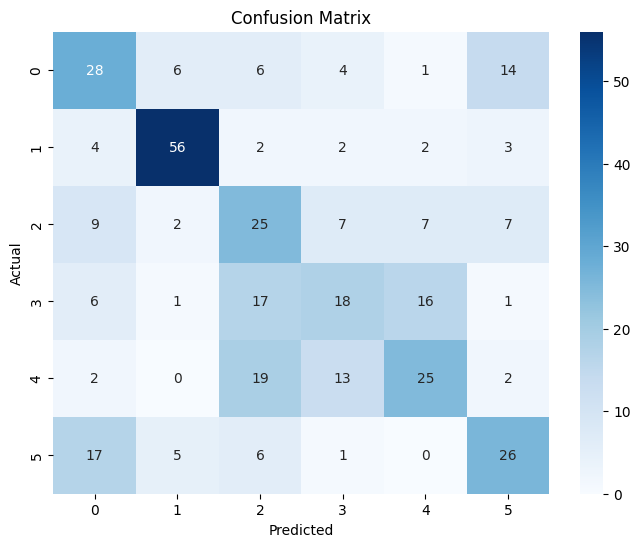

In [33]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

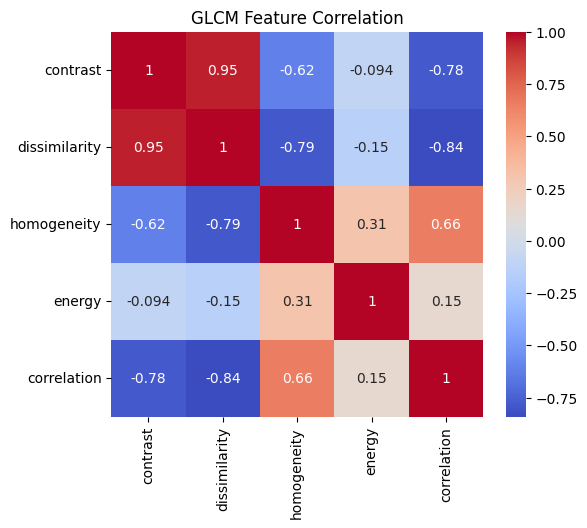

In [34]:
feature_names = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
corr = np.corrcoef(X.T)
plt.figure(figsize=(6,5))
sns.heatmap(corr, xticklabels=feature_names, yticklabels=feature_names, annot=True, cmap="coolwarm")
plt.title("GLCM Feature Correlation")
plt.show()

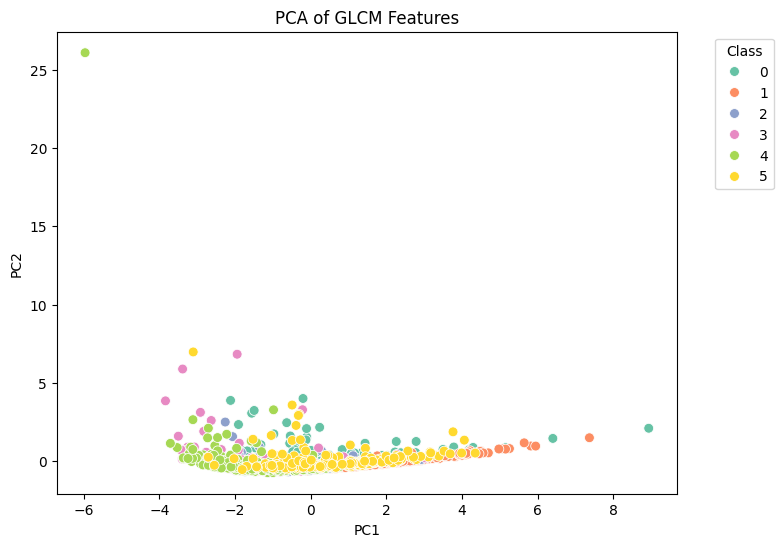

In [35]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y, palette="Set2", s=50)
plt.title("PCA of GLCM Features")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Class", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

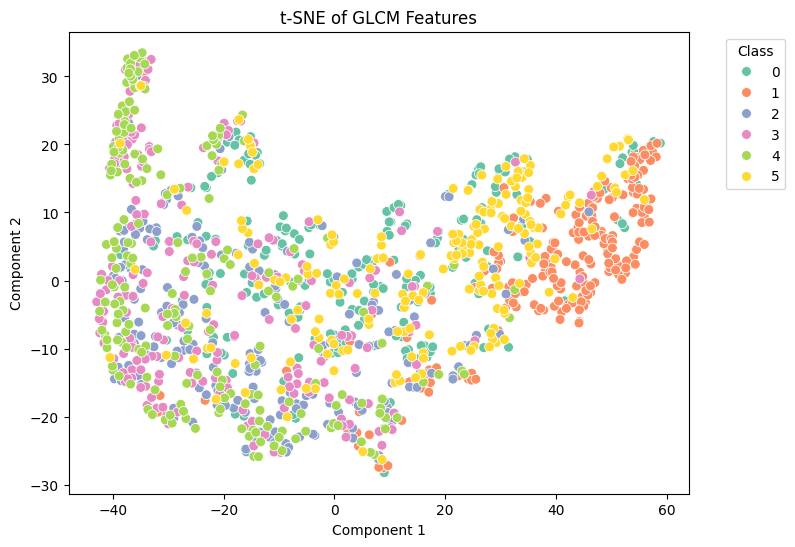

In [36]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=y, palette="Set2", s=50)
plt.title("t-SNE of GLCM Features")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title="Class", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [37]:
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

Classification Report:

              precision    recall  f1-score   support

           0       0.42      0.47      0.45        59
           1       0.80      0.81      0.81        69
           2       0.33      0.44      0.38        57
           3       0.40      0.31      0.35        59
           4       0.49      0.41      0.45        61
           5       0.49      0.47      0.48        55

    accuracy                           0.49       360
   macro avg       0.49      0.49      0.48       360
weighted avg       0.50      0.49      0.49       360

